### Gaussian Process Regression from Scratch
(adapted from martin krauser: (https://colab.research.google.com/github/krasserm/bayesian-machinelearning/
blob/dev/gaussian-processes/gaussian_processes.ipynb)

First we are going to define a plotting function for visualizing GPs

In [ ]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    import matplotlib.pyplot as plt
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In implementing GPR, we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel:

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)\tag{10}
$$

The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic kernel).

In [ ]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    """
    Isotropic squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

### Prior

Let's first define a prior over functions with mean zero and a covariance matrix computed with kernel parameters $l=1$ and $\sigma_f=1$. To draw random functions from that GP we draw random samples from the corresponding multivariate normal. The following example draws three random samples and plots it together with the zero mean and the *uncertainty region* (the 95% highest density interval computed from the diagonal of the covariance matrix).

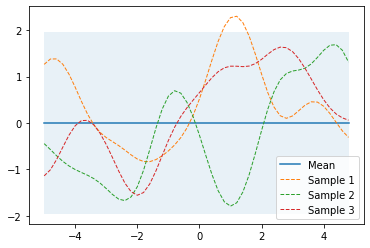

In [ ]:
%matplotlib inline

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples
plot_gp(mu, cov, X, samples=samples)

### Prediction from noise-free training data

To compute the sufficient statistics i.e. mean and covariance of the posterior we implement Equations $(7)$ and $(8)$.

In [ ]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution
    from m training data X_train and Y_train and n new inputs X_s.

    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.

    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)

    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

and apply them to noise-free training data X_train and Y_train. The following example draws three samples from the posterior and plots them along with the mean, uncertainty region and training data. In a noise-free model, variance at the training points is zero and all random functions drawn from the posterior go through the trainig points.

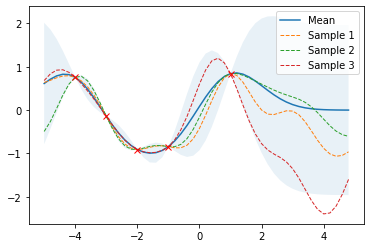

In [ ]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

Prediction from noisy training data
If some noise is included in the model, training points are only approximated and the variance at the training points is non-zero.

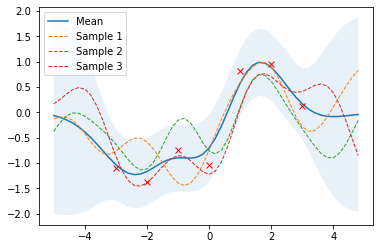

In [ ]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

### Effect of kernel parameters and noise parameter

The following example shows the effect of kernel parameters $l$ and $\sigma_f$ as well as the noise parameter $\sigma_y$. Higher $l$ values lead to smoother functions and therefore to coarser approximations of the training data. Lower $l$ values make functions more wiggly with wide uncertainty regions between training data points. $\sigma_f$ controls the vertical variation of functions drawn from the GP. This can be seen by the wide uncertainty regions outside the training data region in the right figure of the second row. $\sigma_y$ represents the amount of noise in the training data. Higher $\sigma_y$ values make more coarse approximations which avoids overfitting to noisy data.

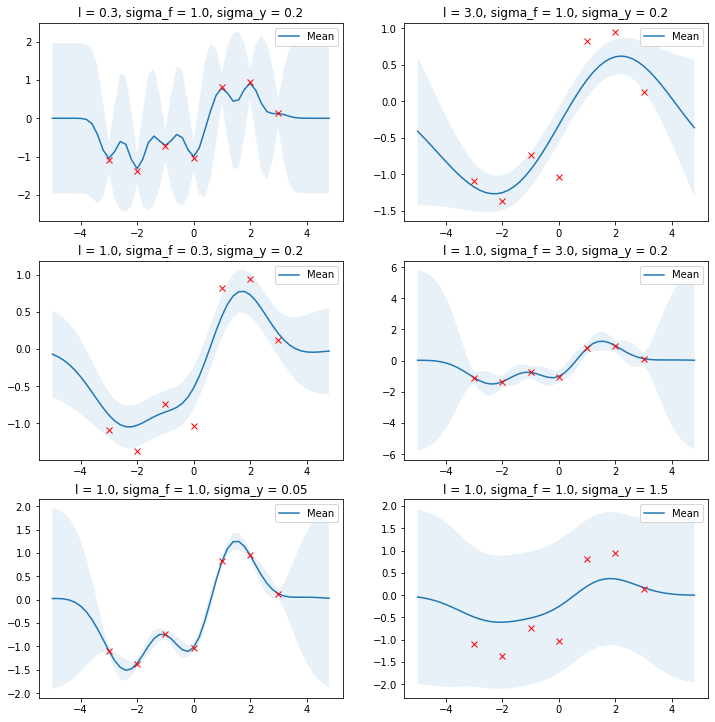

In [ ]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior(X, X_train, Y_train, l=l,
                            sigma_f=sigma_f,
                            sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood which is given by<sup>[1][3]</sup>

$$
\log p(\mathbf{y} \lvert \mathbf{X}) =
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y}
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix}
-\frac{N}{2} \log(2\pi) \tag{11}
$$

In the following we will minimize the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$, $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, $\sigma_y$ can be estimated as well along with the other parameters.

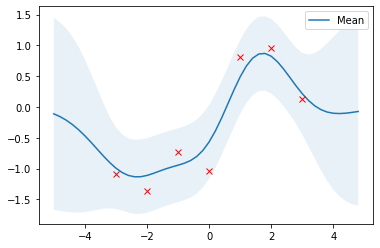

In [ ]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """

    Y_train = Y_train.ravel()

    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples
        # in this article but is numerically less stable compared to
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.

        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)

        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)

        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1],
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x

# Compute posterior mean and covariance with optimized kernel parameters and plot the results
mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)